This code trains 2 ML models on over 3000 images to predict the age and gender from a face. The training set is downloaded from the [IMDB-wiki dataset](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/). The cropped images are zipped up as part of the repo. The pre-trained models being used are the CNNs DenseNet-121 and DenseNet-201. The code to generate the labels from the original matlab file is included, but not necessary to be used. It's recommended to use a cloud notebook with GPU/TPU access such as Google Colab or Kaggle.

# Kernel Setup

In [ ]:
!unzip cropped_pics.zip # if haven't unzipped yet

In [2]:
!pip install tensorflow==2.8.0 # Can use >= 2.2.0

  Using cached tensorflow-2.2.0-cp37-cp37m-macosx_10_11_x86_64.whl (175.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached scipy-1.4.1-cp37-cp37m-macosx_10_6_intel.whl (28.4 MB)
     |████████████████████████████████| 126 kB 1.2 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 8.9 MB 3.9 MB/s eta 0:00:01
  Using cached h5py-2.10.0-cp37-cp37m-macosx_10_6_intel.whl (3.0 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 65 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 400 kB 3.5 MB/s eta 0:00:01
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
     |████████████████████████████████| 152 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 1.9 MB/s eta 0:00:011
     |████████████████████████████████| 181 kB 3.9 MB/s eta 0:00:01
   

In [8]:
!pip install protobuf==3.20.*

     |████████████████████████████████| 981 kB 3.4 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install opencv-python

     |████████████████████████████████| 54.6 MB 2.9 MB/s eta 0:00:01   |                                | 102 kB 2.5 MB/s eta 0:00:23     |█████▋                          | 9.6 MB 3.4 MB/s eta 0:00:14     |██████▌                         | 11.1 MB 3.7 MB/s eta 0:00:12
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from datetime import date

import cv2
import os

from tensorflow.keras.applications import DenseNet201, DenseNet121
from tensorflow.keras.models import load_model
import tensorflow.keras.layers as L

from sklearn.model_selection import train_test_split

# Settings and Functions

In [2]:
############# SETTINGS ################


print(tf.__version__)
print(tf.keras.__version__)


PREDICT_AGE = True

TESTING = False # if testing, use smaller subset of images
TESTING_SIZE = 150

SEED = 2016
IMG_SIZE = 256

EPOCHS = 15
BATCH_SIZE = 32

PATH = os.getcwd() # will be "/content" for Google Colab, or "/kaggle/input" for Kaggle

LABELS_PATH = f"{PATH}/imdb_img_data/labels.csv"
IMAGES_PATH = f"{PATH}/imdb_img_data/"
PRED_PIC_PATH1 = f"{PATH}/testing_pics/hunterPic.jpeg" # pics to manually test
PRED_PIC_PATH2 = f"{PATH}/testing_pics/brookePic.jpeg"


############# FUNCTIONS ###############

def generate_labels_from_matlab_file():
    matlab_labels = scipy.io.loadmat(f'{PATH}/imdb_img_data/imdb_img_data.mat')
    labels_df_raw = pd.DataFrame(matlab_labels['imdb'][0])
    labels_df = pd.DataFrame(data={col : labels_df_raw[col].values[0][0] for col in ['dob','photo_taken','full_path','gender']})
    labels_df['full_path'] = labels_df['full_path'].apply(lambda x: x[0])
    labels_df_full = labels_df[labels_df['full_path'].str.startswith('0')].reset_index(drop=True)
    labels_df_full.to_csv(f'{PATH}/imdb_img_data/labelsFull.csv',index=False)
    labels_df_00 = labels_df_full[labels_df_full['full_path'].str.startswith('00')].reset_index(drop=True)
    labels_df_00.to_csv(f'{PATH}/imdb_img_data/labels.csv',index=False)

def format_image(path):
    img = cv2.imread(IMAGES_PATH + '/' + path)
    img_new = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img_new #/ 255.0
    
def show_image(img):
    new_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(new_img)
    plt.show()

def reshape_list(old_list):
    length = len(old_list)
    new_list = [0]*length
    for i in range(length):
        new_list[i] = old_list[i]

    new_list = np.asarray(new_list)
    return new_list

def learning_rate_schedule(epoch):
    lr_start=0.0001
    lr_max=0.0003
    lr_min=0.00001
    lr_rampup_epochs=5
    lr_sustain_epochs=2
    lr_exp_decay=.7
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

def get_gender_model():
    model = tf.keras.Sequential([
        DenseNet201(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def get_age_model():
    model = tf.keras.Sequential([
        DenseNet121(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae','mse']
    )
    return model


2.2.0
2.3.0-tf


In [3]:
########## LOAD THE DATA ##############

data = pd.read_csv(LABELS_PATH).sort_values(by='full_path').reset_index(drop=True)

print(data.head())
#print(data.describe())


temp_pred_img = cv2.imread(PRED_PIC_PATH1)
pred_img = cv2.resize(temp_pred_img,(IMG_SIZE,IMG_SIZE))
pred_img = pred_img.reshape(1,IMG_SIZE,IMG_SIZE,3) # for getting prediction

temp_pred_img2 = cv2.imread(PRED_PIC_PATH2)
pred_img2 = cv2.resize(temp_pred_img2,(IMG_SIZE,IMG_SIZE))
pred_img2 = pred_img2.reshape(1,IMG_SIZE,IMG_SIZE,3) # for getting prediction

      dob  photo_taken                                    full_path  gender
0  714055         2011  00/nm0000100_rm1001569280_1955-1-6_2011.jpg     1.0
1  714055         2003  00/nm0000100_rm1002674432_1955-1-6_2003.jpg     1.0
2  714055         2011  00/nm0000100_rm1018346496_1955-1-6_2011.jpg     1.0
3  714055         2003  00/nm0000100_rm1019451648_1955-1-6_2003.jpg     1.0
4  714055         2005   00/nm0000100_rm103389184_1955-1-6_2005.jpg     1.0


In [4]:
########## CLEAN AND PREPROCESS DATA ##########


# get labels
if TESTING:
    if PREDICT_AGE:
        train_labels = data[['dob','photo_taken']][:TESTING_SIZE]
    else:
        train_labels = data.gender[:TESTING_SIZE] # also data.dob or data.name
else :
    if PREDICT_AGE:
        train_labels = data[['dob','photo_taken']]
    else:
        train_labels = data.gender



# preprocess age column, specify ages, and set up labels
if PREDICT_AGE:
    train_labels['photo_taken_date'] = train_labels.photo_taken.apply(lambda x: date.toordinal( date(x,7,1) ) )
    train_labels['age_days'] = train_labels.photo_taken_date - train_labels.dob
    train_labels['age'] = train_labels.age_days.apply(lambda x: int (x / 365))
    train_labels = train_labels[ (train_labels.age >= 10) & (train_labels.age < 80) ]
    #train_labels = train_labels.sort_values(by='age',ascending=False) # if I want df to be sorted ascending or descending
    train_labels = train_labels.drop(['dob','photo_taken','photo_taken_date','age_days'],axis=1)




# drop null values 
if (PREDICT_AGE == False):
    train_labels = train_labels.dropna()



# get paths where there are labels
train_paths = data.full_path[train_labels.index]


train_paths = train_paths.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)


print(train_paths.describe())
print(train_labels.describe())



train_images = train_paths.apply(format_image)


print(train_images.shape)
train_images = reshape_list(train_images)
print(train_images.shape)


print(train_labels.head())
#for i in range(5):
#    show_image(train_images[i])


#wait = input('PAUSING')


# splitting data
train_images,valid_images,train_labels,valid_labels = train_test_split(train_images,train_labels,test_size=0.15,random_state=SEED)



count                                             300
unique                                            300
top       00/nm0000100_rm1001569280_1955-1-6_2011.jpg
freq                                                1
Name: full_path, dtype: object
              age
count  300.000000
mean    47.950000
std      6.430032
min     23.000000
25%     44.000000
50%     49.000000
75%     51.000000
max     59.000000
(300,)
(300, 256, 256, 3)
   age
0   55
1   47
2   55
3   47
4   49


In [5]:
########### DEFINE THE MODEL ################

lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)

if PREDICT_AGE:
    model = get_age_model()
else:
    model = get_gender_model()


model.summary()

2023-11-03 14:44:58.868132: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-11-03 14:44:58.889163: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbd25a137d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-03 14:44:58.889180: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [6]:
######## TRAIN THE MODEL ##########

history = model.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr_schedule],
    #steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=(valid_images,valid_labels)
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/15
8/8 [==============================] - 109s 14s/step - loss: 47.6308 - mae: 47.6308 - mse: 2310.7222 - val_loss: 47.8265 - val_mae: 47.8265 - val_mse: 2317.6042 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00014.
Epoch 2/15
8/8 [==============================] - 96s 12s/step - loss: 46.3172 - mae: 46.3172 - mse: 2185.6248 - val_loss: 48.3561 - val_mae: 48.3561 - val_mse: 2368.3828 - lr: 1.4000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00017999999999999998.
Epoch 3/15
8/8 [==============================] - 99s 12s/step - loss: 44.8267 - mae: 44.8267 - mse: 2048.5044 - val_loss: 49.3813 - val_mae: 49.3813 - val_mse: 2466.6003 - lr: 1.8000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00021999999999999998.
Epoch 4/15
8/8 [==============================] - 99s 12s/step - loss: 43.1503 - mae: 43.1503 - mse: 1900.7582 - val_loss:

In [7]:
####### SAVE THE MODEL ###########

if PREDICT_AGE:
    model.save('/Users/huntermitchell/Documents/Documents/PYTHON_FILES/Face_Prediction/age_prediction_model')
else:
    model.save('/Users/huntermitchell/Documents/Documents/PYTHON_FILES/Face_Prediction/gender_prediction_model')


#model.save('current_model_kaggle')

2023-11-03 15:15:20.699188: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/huntermitchell/Documents/Documents/PYTHON_FILES/Face_Prediction/age_prediction_model/assets


[[15.760353]]


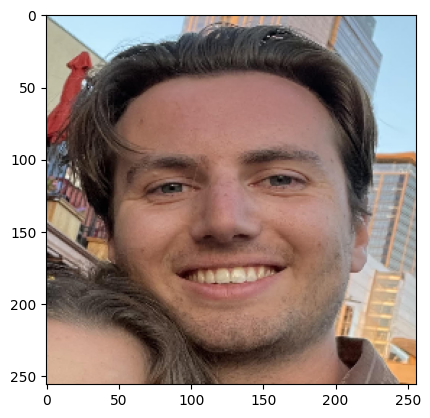

[[15.719702]]


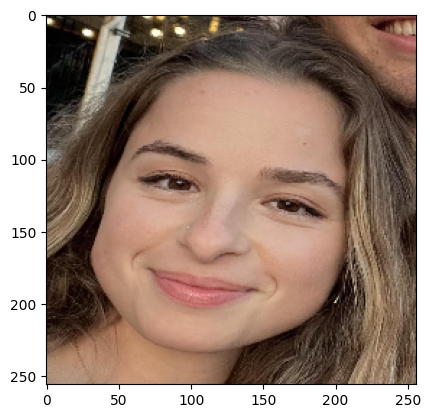

In [8]:
# check predictions 

prediction = model.predict(pred_img)

print(prediction)
show_image(pred_img[0])


prediction2 = model.predict(pred_img2)

print(prediction2)
show_image(pred_img2[0])

In [ ]:
### load model

#model2 = load_model("/kaggle/working/current_model_kaggle")


#prediction = model2.predict(pred_img)

#print(prediction)
#show_image(pred_img[0])


#prediction2 = model2.predict(pred_img2)

#print(prediction2)
#show_image(pred_img2[0])